## GB_Fx-Quarterly_panel


Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['OBX_Energy', 'dI_t', 'Brent', 'Q', 'd_pi', 'EUR_NOK', 'StoxEurope', 'SP500', 'VIX', 'OSEBX']

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

=== Model performance (quarterly mean, EUR/NOK – XGB panel + past macro covariates) ===
Observations: 103
RMSE (level): 0.203607
MAE  (level): 0.146293
Directional accuracy: 75/102 (73.5%)

=== Diebold–Mariano vs Random Walk (XGB panel setup, quarterly) ===
Loss: MSE | horizon h=1
DM-statistic: -1.4902
p-value     : 0.1362


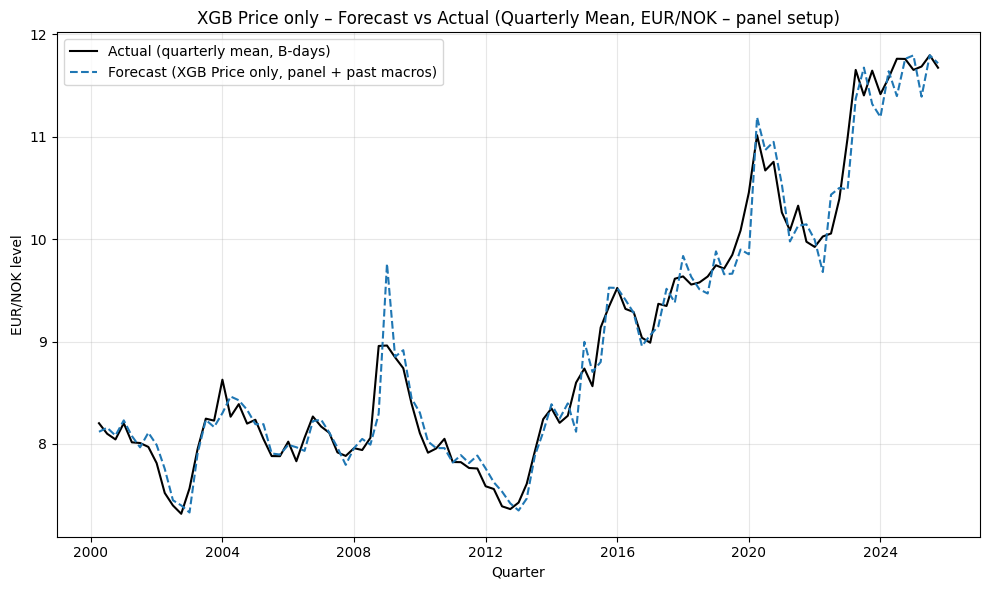

Saved PNG: XGB_PriceOnly_Quarterly_PanelPastCov.png


In [ ]:
# =========================================
# XGB Price only – EUR/NOK walk-forward (quarterly, levels) with daily panel + macro covariates
# PARALLEL OUTER LOOP
#   - Target: EUR_NOK (single series)
#   - Panel predictors: Brent, VIX, StoxEurope, SP500, OSEBX, OBX_Energy + EUR_NOK lags
#   - Macros: Q, d_pi, dI_t as past-only covariates
#   - Data: daily (calendar days), forward-filled
#   - Cut: last business day of previous quarter (based on EUR/NOK B-days)
#   - Forecast: recursive daily next-quarter -> aggregate to quarterly mean over business days
#   - No future covariate paths -> all non-target predictors frozen at last observed level
#   - Metrics: Observations, RMSE, MAE, Directional accuracy
#   - Test: Diebold–Mariano vs Random Walk (MSE, h=1)
#   - Plot: Actual (black) vs Forecast (blue dashed), no intervals
#   - Constraint: n_estimators <= 150
#   - History: uses ENTIRE dataset available in CSV
#   - Output: save ONLY PNG as "XGB_PriceOnly_Quarterly_PanelPastCov.png"
# =========================================

!pip -q install pandas numpy scikit-learn matplotlib requests certifi joblib xgboost

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List

import numpy as np
import pandas as pd
import requests, certifi
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from joblib import Parallel, delayed


# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    # Data source
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )

    # Evaluation granularity
    q_freq: str = "Q-DEC"
    max_lags: int = 20
    max_horizon: int = 128  # must exceed longest quarter (~92 days)

    # Tuned XGB hyperparameters (random search on pre-evaluation panel)
    n_estimators: int = 150
    learning_rate: float = 0.04
    max_depth: int = 6
    min_child_weight: float = 7.0
    subsample: float = 0.6
    colsample_bytree: float = 1.0
    gamma: float = 0.05
    reg_alpha: float = 0.2
    reg_lambda: float = 0.5

    # Fixed model choices (not part of tuning)
    tree_method: str = "hist"
    objective: str = "reg:squarederror"
    eval_metric: str = "rmse"
    random_state: int = 42

    # Misc
    retries: int = 3
    timeout: int = 60
    verbose: bool = True

    # PNG only
    fig_png: str = "XGB_PriceOnly_Quarterly_PanelPastCov.png"


CFG = Config()

TARGET_SERIES = "EUR_NOK"
PANEL_SERIES = [
    "EUR_NOK",
    "Brent",
    "VIX",
    "StoxEurope",
    "SP500",
    "OSEBX",
    "OBX_Energy",
]
MACRO_COLS = ["Q", "d_pi", "dI_t"]

ALL_PREDICTORS = PANEL_SERIES + MACRO_COLS


# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV with retry/backoff."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")


# -----------------------------
# Data loading: daily wide DF + EUR/NOK business-day series
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Expected columns:
      Date, EUR_NOK, Q, d_pi, dI_t, Brent, VIX, StoxEurope, SP500, OSEBX, OBX_Energy

    Returns:
      S_b  : EUR_NOK on business days (B) with ffill (cuts + truth)
      DF_d : daily (D) wide DataFrame with ALL_PREDICTORS,
             calendar days, forward-filled
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date"} | set(ALL_PREDICTORS)
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", TARGET_SERIES])
        .sort_values("DATE")
        .set_index("DATE")
    )

    for col in ALL_PREDICTORS:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=[TARGET_SERIES])

    if df.empty:
        raise ValueError("Dataset is empty after cleaning.")

    # EUR/NOK on business days only (truth + cut calendar)
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Daily wide DF (calendar days), ffilled
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Return last business day within [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


# -----------------------------
# Feature engineering: multivariate lag matrix
# -----------------------------
def make_lag_matrix(
    df_hist: pd.DataFrame,
    predictors: List[str],
    max_lags: int
) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """
    Build X, y for one-step ahead daily forecasting of EUR_NOK.

    X_t = stacked lags of all predictors:
      [pred1_{t-1..t-L}, pred2_{t-1..t-L}, ...]
    y_t = EUR_NOK_t
    """
    work = df_hist[predictors].copy()
    lag_cols: List[str] = []

    for var in predictors:
        for k in range(1, max_lags + 1):
            name = f"{var}_lag{k}"
            work[name] = work[var].shift(k)
            lag_cols.append(name)

    work = work.dropna()
    X = work[lag_cols].values
    y = work[TARGET_SERIES].values
    return X, y, lag_cols


# -----------------------------
# XGBoost one-step model (NO validation split)
# -----------------------------
def fit_xgb_one_step(df_hist_daily: pd.DataFrame) -> Tuple[XGBRegressor, List[str]]:
    """Fit XGB for one-step daily prediction using lags of panel + macros."""
    X, y, lag_cols = make_lag_matrix(df_hist_daily, ALL_PREDICTORS, CFG.max_lags)

    if len(X) < 5:
        raise ValueError("Too few observations after lagging to fit model.")

    model = XGBRegressor(
        n_estimators=CFG.n_estimators,
        learning_rate=CFG.learning_rate,
        max_depth=CFG.max_depth,
        min_child_weight=CFG.min_child_weight,
        subsample=CFG.subsample,
        colsample_bytree=CFG.colsample_bytree,
        gamma=CFG.gamma,
        reg_alpha=CFG.reg_alpha,
        reg_lambda=CFG.reg_lambda,
        objective=CFG.objective,
        eval_metric=CFG.eval_metric,
        tree_method=CFG.tree_method,
        random_state=CFG.random_state,
        n_jobs=1
    )
    model.fit(X, y)
    return model, lag_cols


def recursive_daily_forecast(
    model: XGBRegressor,
    df_hist_daily: pd.DataFrame,
    H: int
) -> pd.Series:
    """
    Produce H daily forecasts recursively.

    Anti-leakage:
      - all non-target predictors frozen at last observed level
      - only EUR_NOK updated with predictions
    """
    hist = df_hist_daily[ALL_PREDICTORS].copy()
    last_vals = hist.iloc[-1].to_dict()  # frozen snapshot

    preds = []
    for _ in range(H):
        if len(hist) < CFG.max_lags:
            raise ValueError("Not enough history for lag features.")

        row_feats = []
        for var in ALL_PREDICTORS:
            lags = hist[var].iloc[-CFG.max_lags:][::-1].values
            row_feats.extend(lags.tolist())

        x = np.array(row_feats, dtype=float).reshape(1, -1)
        yhat = float(model.predict(x)[0])
        preds.append(yhat)

        new_row = last_vals.copy()
        new_row[TARGET_SERIES] = yhat
        new_idx = hist.index[-1] + pd.Timedelta(days=1)
        hist = pd.concat([hist, pd.DataFrame([new_row], index=[new_idx])])

    return pd.Series(preds)


# -----------------------------
# Quarterly walk-forward using XGB + panel/macros (past-only)
# PARALLEL outer loop
# -----------------------------
def walk_forward_xgb_quarterly_panel_pastcov_parallel(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    n_jobs_outer: int = -1,
    backend: str = "loky"
) -> pd.DataFrame:
    """
    For each calendar quarter q:
      - cut at last business day of previous quarter
      - fit XGB on daily history up to cut
      - recursively forecast full next quarter daily
      - aggregate forecasts to business-day quarterly mean
    """
    first_q = pd.Period(S_b.index.min(), freq=CFG.q_freq)
    last_q  = pd.Period(S_b.index.max(), freq=CFG.q_freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG.q_freq)

    def _process_one_quarter(q: pd.Period):
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time
        prev_start, prev_end = prev_q.start_time, prev_q.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            return (str(q), None, "no_cut_in_prev_quarter")

        hist_df = DF_d.loc[:cut]
        if hist_df.shape[0] <= CFG.max_lags:
            return (str(q), None, "hist<=max_lags")

        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            return (str(q), None, "no_bdays_in_quarter")
        y_true = float(S_b.loc[idx_q_b].mean())

        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            return (str(q), None, f"horizon_invalid(H={H})")

        model, _ = fit_xgb_one_step(hist_df)
        pf = recursive_daily_forecast(model, hist_df, H)

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf.values, index=f_idx, name="point")

        pred_b = pred_daily.reindex(idx_q_b, method=None)
        if pred_b.isna().all():
            return (str(q), None, "no_overlap_pred_B_days")
        y_pred = float(pred_b.dropna().mean())

        row = {"quarter": q, "cut": cut, "y_true": y_true, "y_pred": y_pred}
        return (str(q), row, None)

    results = Parallel(n_jobs=n_jobs_outer, backend=backend)(
        delayed(_process_one_quarter)(q) for q in quarters
    )

    rows: Dict[str, dict] = {}
    dropped: Dict[str, str] = {}

    for key, row, reason in results:
        if row is not None:
            rows[key] = row
        else:
            dropped[key] = reason or "unknown"

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("quarter").sort_index()

    if CFG.verbose and dropped:
        miss = [str(q) for q in quarters if str(q) not in rows]
        if miss:
            print("\nDropped quarters and reasons:")
            for qq in miss:
                print(f"  {qq}: {dropped.get(qq, 'unknown')}")

    return df


# -----------------------------
# Evaluation (level + direction)
# -----------------------------
def evaluate(eval_df: pd.DataFrame) -> pd.DataFrame:
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (quarterly mean, EUR/NOK – XGB panel + past macro covariates) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core


# -----------------------------
# Diebold–Mariano (vs Random Walk)
# -----------------------------
def _normal_cdf(z: float) -> float:
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(
    y_true: pd.Series,
    y_model: pd.Series,
    y_rw: pd.Series,
    h: int = 1,
    loss: str = "mse"
) -> Tuple[float, float]:
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val

def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1) -> None:
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk (XGB panel setup, quarterly) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")


# -----------------------------
# Plot (PNG only, no bands)
# -----------------------------
def plot_quarterly_simple(eval_df: pd.DataFrame, png_path: str):
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (quarterly mean, B-days)")
    plt.plot(
        x, eval_df["y_pred"],
        color="tab:blue", linestyle="--",
        label="Forecast (XGB Price only, panel + past macros)"
    )

    plt.title("XGB Price only – Forecast vs Actual (Quarterly Mean, EUR/NOK – panel setup)")
    plt.xlabel("Quarter")
    plt.ylabel("EUR/NOK level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved PNG: {png_path}")


# -----------------------------
# Main
# -----------------------------
def main():
    S_b, DF_d = load_series(CFG.url)
    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    df_eval = walk_forward_xgb_quarterly_panel_pastcov_parallel(S_b, DF_d, n_jobs_outer=-1)
    eval_df = evaluate(df_eval)

    dm_against_random_walk(eval_df, loss="mse", h=1)
    plot_quarterly_simple(eval_df, CFG.fig_png)

if __name__ == "__main__":
    main()
